In [1]:
%pylab inline
%load_ext autoreload
%autoreload 1
%aimport new_CCA
%aimport sample_gen
from scipy.stats import multivariate_normal
from collections import defaultdict
%aimport cca_compare

Populating the interactive namespace from numpy and matplotlib


In [27]:
n_bands = 10
n_samples = 1000
d1 = sample_gen.create_distribution(n_bands,mean_std_scale=0.3,std=1)
d2 = sample_gen.create_distribution(n_bands,mean_std_scale=1,std=2,std_scale=0.1)
X = d1.rvs(n_samples)
Y = X+d2.rvs(n_samples)

In [28]:
# Generate samples
def gen_samples(sample_size,n_bands=3):
    X = np.random.normal(0,1,size=(sample_size,n_bands))
    Y = X+np.random.normal(0,0.5,size=(sample_size,n_bands))
    return X,Y

# Print info about cca
def cca_info(X,Y, A, B):
    
    prev_u = None
    prev_v = None
    
    for i,(a,b) in enumerate( zip(A.T,B.T) ):
        print('{} cannonical variates pair'.format(i+1))
                
        u = np.dot( X,a )
        v = np.dot( Y,b )

        if prev_u is not None and prev_v is not None:
            print('prev corrcoef:\n{: <10.4f}{: <10.4f}\n{: <10.4f}{: <10.4f}'.format( 
                np.corrcoef(u,prev_u)[0,1], np.corrcoef(u,prev_v)[0,1],
                np.corrcoef(v,prev_u)[0,1], np.corrcoef(v,prev_v)[0,1]
            ))
        prev_u = u
        prev_v = v

        print('corrcoef: {:.4f}'.format(np.corrcoef(u,v)[0,1]))

        # Fit u more tightly to v
        reg = LinearRegression()
        reg.fit(u[:,np.newaxis],v)
        new_u = reg.predict(u[:,np.newaxis])

        plot(new_u[:10],'C0-',label='u')
        plot(u[:10],'C0--')
        plot(v[:10],'C1',label='v')
        legend()
        show()
        
def random_subsample(sample_size,*args):
    ret = []
    ids = np.array([i for i in range(len(args[0]))])
    np.random.shuffle(ids)
    
    for arg in args:
        ret.append(np.array(arg)[ids][:sample_size])
        
    return ret

nastyCorr = None
nastyX = None
nastyY = None

# Compare CCA
def cca_compare(X,Y, funcs_dict, x_samples = 20, n_probas = 10,train_eval=False):
    
    func_labels = list(funcs_dict.keys())
    funcs = [funcs_dict[i] for i in func_labels]
    
    sample_sizes = []
    
    correlations_mean = defaultdict(list)
    correlations_max = defaultdict(list)
    correlations_min = defaultdict(list)
    
    for sample_size in np.linspace(int(X.shape[0]*0.2),X.shape[0],x_samples).astype(np.int):
        sample_sizes.append(sample_size)
        
        for func in funcs:

            corr_pack_mean = []
            corr_pack_max = []
            corr_pack_min = []
            
            for n_proba in range(n_probas):
                corr_pack = []
            
                Xs,Ys = random_subsample(sample_size,X,Y)
                A,B = func(Xs,Ys)
            
                for i,(a,b) in enumerate( zip(A.T,B.T) ):
                    if train_eval:
                        u = np.dot( Xs,a )
                        v = np.dot( Ys,b )
                    else:
                        u = np.dot( X,a )
                        v = np.dot( Y,b )
                    corr_pack.append( np.abs( np.corrcoef(u,v)[0,1] ) )

                global nastyCorr
                if np.array(corr_pack).max() > 0 and (nastyCorr is None or nastyCorr > np.array(corr_pack).max() ):
                    global nastyX
                    global nastyY
                    global nastyCorr
                    nastyX = Xs
                    nastyY = Ys
                    nastyCorr = np.array(corr_pack).max()
                    print("nastyCorr: {}".format(nastyCorr))
                    
                corr_pack_mean.append(corr_pack)

            correlations_min[func].append( np.percentile(corr_pack_mean,1,axis=0) )
            correlations_mean[func].append( np.percentile(corr_pack_mean,50,axis=0) )
            correlations_max[func].append( np.percentile(corr_pack_mean,99,axis=0) )
    
    corr_by_func_min = defaultdict(lambda: defaultdict(list))
    corr_by_func_mean = defaultdict(lambda: defaultdict(list))
    corr_by_func_max = defaultdict(lambda: defaultdict(list))
    
    for func_id,func in enumerate(funcs):
        for component_id, component_corr in enumerate( np.array( correlations_min[func] ).T ):
            corr_by_func_min[component_id][func_id] = component_corr
        for component_id, component_corr in enumerate( np.array( correlations_mean[func] ).T ):
            corr_by_func_mean[component_id][func_id] = component_corr
        for component_id, component_corr in enumerate( np.array( correlations_max[func] ).T ):
            corr_by_func_max[component_id][func_id] = component_corr
        
    for component_id in corr_by_func_mean.keys():
        for func_i,(func,label) in enumerate( zip(funcs,func_labels) ):
            
            if func_i not in corr_by_func_mean[component_id]:
                continue
                
            color = 'C{}'.format(func_i)
            
            min_x  = corr_by_func_min[component_id][func_i]
            mean_x = corr_by_func_mean[component_id][func_i]
            max_x  = corr_by_func_max[component_id][func_i]
            
            plot(sample_sizes, mean_x,color,label=label)
            fill_between(sample_sizes,min_x,max_x,facecolor=color,alpha=0.1)
        
        grid(True)
        title('Comparison of CCA. Band {}'.format(component_id))
        xlabel("sub-Sample size")
        ylabel("Correlation")
        legend()
        show()

<ipython-input-28-f41b1bc6de61>:94: SyntaxWarning: name 'nastyCorr' is used prior to global declaration
  global nastyCorr


# CCA from sklearn

In [29]:
from sklearn.cross_decomposition import CCA
from new_CCA import cca
def sklearn_cca(X,Y,n_components=10):
    cca_instance = CCA(n_components=n_components)
    cca_instance.fit(X,Y)    
    return cca_instance.x_rotations_, cca_instance.y_rotations_

In [6]:
cca_compare.cca_compare(X,Y,{"sklearn":sklearn_cca,"cca3":cca})

AttributeError: 'function' object has no attribute 'cca_compare'

## CCA test fitness

In [31]:
a, b, r = new_CCA.cca(X,Y)
u = np.dot( X,a )
v = np.dot( Y,b )

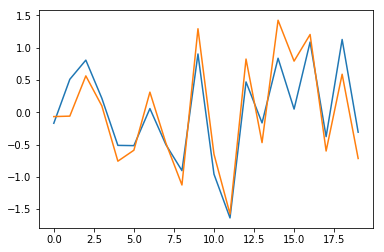

In [33]:
plot(u[:20,0]-u[:20,0].mean())
plot(v[:20,0]-v[:20,0].mean());

In [37]:
from scipy.linalg import sqrtm

# Correlation function
def calc_covariance(xy_sum,x_sum,y_sum,n):
    """
    calculate covariance matrix of 2 variables
    """
    return ( xy_sum - np.matmul(x_sum,y_sum.T)/n )/(n-1)

def calc_linear_regression(n,a,b,x_sum, y_sum, xy_sum, xx_sum ):
    m1 = np.array([[n,(a @ x_sum)[0]],
                  [(a @ x_sum)[0],((a[:,np.newaxis] @ a[:,np.newaxis].T) * xx_sum).sum()]])
    m2 = np.array([
        (b @ y_sum)[0],
        ( ( a[:,np.newaxis] @ b[np.newaxis,:] ) * ( xy_sum ) ).sum()
    ])
    return np.linalg.inv(m1) @ m2

In [124]:
x = X
y = Y

x_sum = np.sum(x,axis=0)[:,np.newaxis]
y_sum = np.sum(y,axis=0)[:,np.newaxis]
xy_sum = np.transpose(x) @ y
xx_sum = np.transpose(x) @ x
yy_sum = np.transpose(y) @ y
n = np.shape(x)[0]

xy_cov = calc_covariance(xy_sum,x_sum,y_sum,n)
xx_cov = calc_covariance(xx_sum,x_sum,x_sum,n)
yy_cov = calc_covariance(yy_sum,y_sum,y_sum,n)


xx_cov_sqrt_inv = np.linalg.inv( sqrtm(xx_cov) )
yy_cov_sqrt_inv = np.linalg.inv( sqrtm(yy_cov) )

u_mat = xx_cov_sqrt_inv @ xy_cov @ np.linalg.inv(yy_cov) @ xy_cov.T @ xx_cov_sqrt_inv
u_eigvals,u_eigvecs = np.linalg.eig(u_mat)

v_mat = yy_cov_sqrt_inv @ xy_cov.T @ np.linalg.inv(xx_cov) @ xy_cov @ yy_cov_sqrt_inv
v_eigvals,v_eigvecs = np.linalg.eig(v_mat)

# Sort eigenvectors by their eigenvalues
# The hypothisis here is that correlation is bigger if eigenvalue of eigenvector is bigger
u = u_eigvecs.T[sorted([i for i in range(len(u_eigvals))], key=lambda x: -u_eigvals[x])]
v = v_eigvecs.T[sorted([i for i in range(len(v_eigvals))], key=lambda x: -v_eigvals[x])]

a = (u @ xx_cov_sqrt_inv).T
b = (v @ yy_cov_sqrt_inv).T

regressions = np.array( [ calc_linear_regression(n,a[:,i],b[:,i],x_sum, y_sum, xy_sum, xx_sum ) for i in range(a.shape[1]) ] )
#a = a*regressions[:,1]

u = np.dot( X,a )
v = np.dot( Y,b )

print('first pair corr: {:.2f}'.format(np.corrcoef(u[:,0],v[:,0])[0,1]))

first pair corr: -0.90


# IMPORTANT!!!
## Below - formula for u1v1+u2v2+u3v3+...unvn described through xy_sum terms and a,b

This is an essential part for calculating linear regression for target variable v and features u without actually calculating them
This represents term X^{T} y

In [20]:
print( (u[:,0] * v[:,0]).sum() )
print( ( ( a[:,0,np.newaxis] @ b[np.newaxis,:,0] ) * ( xy_sum ) ).sum() )

80305707.4869
80305707.4869


# Next step - calculate term u^{T} u

# Formula for \Sum_i u_i and \Sum_i v_i

In [44]:
# u[:,0].sum()
a[:,0] @ x_sum

array([ 88597.47589169])

In [63]:
#v[:,0].sum()
b[:,0] @ y_sum

array([ 906400.81597157])

# Formula for \Sum_i u^2_i

In [60]:
#(u[:,0]**2).sum()
((a[:,0,np.newaxis] @ a[:,0,np.newaxis].T) * xx_sum).sum()

7850511.7343779588

# Assemble matrices

In [79]:
betas_true = np.array([
    v[:,0].sum(),
    (u[:,0]*v[:,0]).sum(),
])
betas_true

array([   906400.81597157,  80305707.48691505])

In [134]:
m1 = np.array([[n,(a[:,0] @ x_sum)[0]],
                  [(a[:,0] @ x_sum)[0],((a[:,0,np.newaxis] @ a[:,0,np.newaxis].T) * xx_sum).sum()]])

m2 = np.array([
    (b[:,0] @ y_sum)[0],
    ( ( a[:,0,np.newaxis] @ b[np.newaxis,:,0] ) * ( xy_sum ) ).sum()
    ])

betas = np.linalg.inv(m1) @ m2
betas

array([ 828.08688466,    0.8839296 ])

In [106]:
np.array([[n,u[:,0].sum()],[u[:,0].sum(),(u[:,0]*u[:,0]).sum() ]])

array([[  1.00000000e+03,   8.85974759e+04],
       [  8.85974759e+04,   7.85051173e+06]])

In [156]:
def calc_linear_regression(n,a,b,x_sum, y_sum, xy_sum, xx_sum ):
    m1 = np.array([[n,(a @ x_sum)[0]],
                  [(a @ x_sum)[0],((a[:,np.newaxis] @ a[:,np.newaxis].T) * xx_sum).sum()]])
    m2 = np.array([
        (b @ y_sum)[0],
        ( ( a[:,np.newaxis] @ b[np.newaxis,:] ) * ( xy_sum ) ).sum()
    ])
    return np.linalg.inv(m1) @ m2

In [174]:
(a*[1,2,3,4,5,6,7,8,9,10])[:,0]/a[:,0]

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

In [175]:
np.array( [ calc_linear_regression(n,a[:,i],b[:,i],x_sum, y_sum, xy_sum, xx_sum ) for i in range(a.shape[1]) ] )

array([[  8.28086885e+02,   8.83929599e-01],
       [  1.43527813e+02,   8.76378135e-01],
       [  7.76457751e+02,  -8.60392314e-01],
       [ -4.05214764e+02,   8.11294724e-01],
       [  4.85224825e+02,   8.05766142e-01],
       [ -2.66750776e+02,  -7.51280307e-01],
       [ -4.24498204e+02,   7.33004614e-01],
       [  2.27644995e+02,  -6.89955448e-01],
       [ -4.54891459e+02,  -6.06604994e-01],
       [ -4.30853681e+02,  -5.84572284e-01]])

In [159]:
calc_linear_regression(n,a[:,0],b[:,0],x_sum, y_sum, xy_sum, xx_sum )

array([ 828.08688466,    0.8839296 ])

In [131]:
a[:,0][:,np.newaxis] @ b[:,0][np.newaxis,:]

array([[  4.78160620e-02,  -5.31702148e-04,  -3.25972763e-02,
          3.27168577e-02,  -3.78314881e-02,   8.71486269e-02,
          2.81651673e-02,   3.05234962e-02,  -4.74690311e-02,
         -1.20739034e-02],
       [ -4.42607429e-04,   4.92167926e-06,   3.01735359e-04,
         -3.02842261e-04,   3.50185628e-04,  -8.06687714e-04,
         -2.60709723e-04,  -2.82539499e-04,   4.39395152e-04,
          1.11761594e-04],
       [ -3.28047061e-02,   3.64779783e-04,   2.23637001e-02,
         -2.24457402e-02,   2.59546855e-02,  -5.97892210e-02,
         -1.93230056e-02,  -2.09409617e-02,   3.25666220e-02,
          8.28342685e-03],
       [  3.68262065e-02,  -4.09497819e-04,  -2.51052466e-02,
          2.51973439e-02,  -2.91364478e-02,   6.71187295e-02,
          2.16917961e-02,   2.35080960e-02,  -3.65589358e-02,
         -9.29888493e-03],
       [ -4.12444212e-02,   4.58627215e-04,   2.81172421e-02,
         -2.82203888e-02,   3.26320857e-02,  -7.51712819e-02,
         -2.42942638e-02

In [128]:
b[np.newaxis,:,0]

array([[-0.20788406,  0.00231162,  0.1417192 , -0.14223909,  0.16447535,
        -0.37888545, -0.12245026, -0.13270328,  0.20637532,  0.05249224]])

In [115]:
def calc_linear_regression(x,y):
    n = x.shape[0]
    m1 = np.array([[n,x.sum()],[x.sum(),(x*x).sum()]])
    m2 = np.array([[y.sum()],[(x*y).sum()]])
    return np.linalg.inv(m1) @ m2
    
calc_linear_regression(u[:,0],v[:,0])

array([[ 828.08688468],
       [   0.8839296 ]])

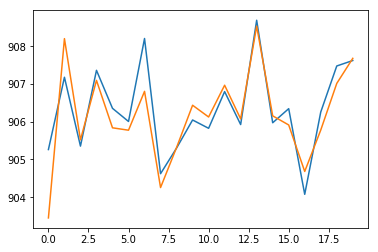

In [124]:
plot( (u[:,0]*0.8839296+828.08688468)[:20] );
plot(v[:20,0]);

# Test new code

In [225]:
a,b,r = new_CCA.cca(X,Y)
u = np.dot( X,a )
v = np.dot( Y,b )

In [226]:
r[:,np.newaxis]

array([[ 104.89203809],
       [ 386.36789791],
       [ 746.19146395],
       [-416.67535132],
       [-810.90425694],
       [ 524.18903327],
       [ 319.85110123],
       [ 342.95007305],
       [-429.89034695],
       [ -36.03504837]])

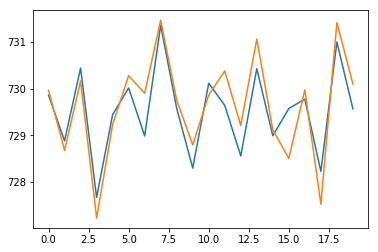

In [227]:
plot( (u+r)[:20,1] )
plot( v[:20,1] )

In [7]:
import pandas as pd

In [126]:
target_file = "./test_files/"
pd.DataFrame(Y).to_csv("{}test_Y.csv".format(target_file),index=False,header=False)
pd.DataFrame(X).to_csv("{}test_X.csv".format(target_file),index=False,header=False)

pd.DataFrame(xx_cov).to_csv("{}xx_cov.csv".format(target_file),index=False,header=False)
pd.DataFrame(xy_cov).to_csv("{}xy_cov.csv".format(target_file),index=False,header=False)
pd.DataFrame(yy_cov).to_csv("{}yy_cov.csv".format(target_file),index=False,header=False)

pd.DataFrame(xx_cov_sqrt_inv).to_csv("{}xx_cov_sqrt_inv.csv".format(target_file),index=False,header=False)
pd.DataFrame(yy_cov_sqrt_inv).to_csv("{}yy_cov_sqrt_inv.csv".format(target_file),index=False,header=False)

pd.DataFrame(u).to_csv("{}test_U.csv".format(target_file),index=False,header=False)
pd.DataFrame(v).to_csv("{}test_V.csv".format(target_file),index=False,header=False)

pd.DataFrame(a).to_csv("{}test_a.csv".format(target_file),index=False,header=False)
pd.DataFrame(b).to_csv("{}test_b.csv".format(target_file),index=False,header=False)
pd.DataFrame(x_sum).to_csv("{}x_sum.csv".format(target_file),index=False,header=False)
pd.DataFrame(xx_sum).to_csv("{}xx_sum.csv".format(target_file),index=False,header=False)
pd.DataFrame(xy_sum).to_csv("{}xy_sum.csv".format(target_file),index=False,header=False)
pd.DataFrame(yy_sum).to_csv("{}yy_sum.csv".format(target_file),index=False,header=False)
pd.DataFrame(y_sum).to_csv("{}y_sum.csv".format(target_file),index=False,header=False)

In [58]:
x_sum

array([[ -212855.39576137],
       [ -663243.578226  ],
       [ 1201742.63940914],
       [ -288892.16590873],
       [-1052210.49679325],
       [  538484.23786883],
       [  930039.45350729],
       [ -439686.48307657],
       [ -914135.15990369],
       [  365887.76707702]])

In [59]:
X[1,5]

538.3001599290676

In [60]:
x_sum

array([[ -212855.39576137],
       [ -663243.578226  ],
       [ 1201742.63940914],
       [ -288892.16590873],
       [-1052210.49679325],
       [  538484.23786883],
       [  930039.45350729],
       [ -439686.48307657],
       [ -914135.15990369],
       [  365887.76707702]])

In [94]:
eigenvals,eigenvecs = np.linalg.eig( xx_sum )

E = np.diag( eigenvals )
V = eigenvecs

# E,V
# E - matrix with eigenvalues on diagonal
# V - matrix with eigenvectors

# sqrtMatrix = V * sqrt(E) * V^T

res = V @ sqrt(E) @ V.T

In [77]:
sqrt(E)

array([[ 2.02185443,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  1.2398957 ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  1.79356907,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.73095073,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  1.65738104,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.62523047,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  1.33462598,  0.        

In [68]:
eigenvals

array([ 4.08789534,  1.53734134,  3.21689003,  2.99619044,  2.7469119 ,
        2.64137408,  1.7812265 ,  1.96074828,  2.22568051,  2.20785013])

In [62]:
xx_cov_sqrt_inv

array([[  6.67997787e-01,  -1.17449730e-02,   1.49002634e-02,
         -1.48511383e-02,  -1.71385863e-02,  -1.36851930e-02,
          1.78444156e-02,   5.43476619e-03,   1.84246380e-02,
          5.05149442e-03],
       [ -1.17449730e-02,   6.33873451e-01,   1.97614561e-02,
         -2.66482759e-02,   3.04971526e-02,  -2.16666129e-03,
          2.81286975e-03,   1.80311311e-02,   8.57148871e-03,
         -4.81365669e-04],
       [  1.49002634e-02,   1.97614561e-02,   7.83189532e-01,
         -1.51906075e-02,  -7.35931376e-03,   6.12518646e-03,
         -1.77802967e-02,  -3.18482370e-02,   1.79145655e-02,
          1.19312645e-03],
       [ -1.48511383e-02,  -2.66482759e-02,  -1.51906075e-02,
          5.73082941e-01,  -2.25690411e-02,   1.63994523e-02,
          2.96270727e-02,   1.78104932e-04,  -9.89009937e-03,
          2.19416829e-02],
       [ -1.71385863e-02,   3.04971526e-02,  -7.35931376e-03,
         -2.25690411e-02,   6.42555329e-01,  -7.67722227e-04,
         -1.62609747e-02

In [128]:
sqrtm(xx_cov)

array([[  1.50336399e+00,   2.98473689e-02,  -2.88784064e-02,
          4.22510109e-02,   4.00152309e-02,   3.40430208e-02,
         -4.08268096e-02,  -1.31991550e-02,  -4.29775342e-02,
         -1.81513197e-02],
       [  2.98473689e-02,   1.58736773e+00,  -4.15164791e-02,
          7.08728658e-02,  -7.23746184e-02,   6.39381672e-03,
         -1.33117894e-02,  -4.01782399e-02,  -1.72534721e-02,
         -4.64147929e-04],
       [ -2.88784064e-02,  -4.15164791e-02,   1.28331216e+00,
          3.04003753e-02,   1.85724478e-02,  -1.83682116e-02,
          3.35943846e-02,   5.78699860e-02,  -3.72992611e-02,
         -5.33129641e-03],
       [  4.22510109e-02,   7.08728658e-02,   3.04003753e-02,
          1.76109138e+00,   5.81814006e-02,  -4.71677010e-02,
         -7.57168517e-02,   5.75105518e-04,   2.20848766e-02,
         -7.86310799e-02],
       [  4.00152309e-02,  -7.23746184e-02,   1.85724478e-02,
          5.81814006e-02,   1.56492267e+00,   6.27059400e-05,
          3.38898283e-02

In [199]:
v_mat = yy_cov_sqrt_inv @ xy_cov.T @ np.linalg.inv(xx_cov) @ xy_cov @ yy_cov_sqrt_inv
v_eigvals,v_eigvecs = np.linalg.eig(v_mat)

In [208]:
v_eigvecs.T[sorted([i for i in range(len(v_eigvals))], key=lambda x: -v_eigvals[x])]

array([[ 0.2844987 , -0.07001492, -0.07887122,  0.51099811,  0.2823189 ,
         0.33677274, -0.27750716, -0.02070831,  0.08492399, -0.60749295],
       [-0.05662517, -0.09499848, -0.05955275, -0.5265342 ,  0.2675997 ,
         0.55596149,  0.47277099,  0.03125079, -0.1836721 , -0.26087708],
       [ 0.4931477 ,  0.31832179, -0.1242738 , -0.2654531 , -0.48488354,
         0.02122145, -0.21241347, -0.18509903, -0.46804976, -0.18855543],
       [-0.16833211, -0.14742565, -0.05672543, -0.29882808, -0.10696044,
        -0.50124127, -0.07057298,  0.46509529,  0.08678257, -0.60490102],
       [-0.13018296,  0.46614879,  0.28866862,  0.36748688, -0.05811112,
        -0.22284771,  0.60601899, -0.1346    , -0.16075032, -0.28831697],
       [ 0.47048122, -0.66474253,  0.01483726,  0.09550123,  0.0760754 ,
        -0.34586098,  0.34809087, -0.19219136, -0.2061333 ,  0.03769833],
       [-0.46671665, -0.18030413,  0.10763471,  0.13286177,  0.18910358,
        -0.03298706, -0.29766942, -0.02281721